# Introduction
Text Classification can be used to solve various use-cases like sentiment analysis, spam detection, hashtag prediction etc. This notebook demonstrates the use of SageMaker BlazingText to perform supervised binary/multi class with single or multi label text classification. BlazingText can train the model on more than a billion words in a couple of minutes using a multi-core CPU or a GPU, while achieving performance on par with the state-of-the-art deep learning text classification algorithms. BlazingText extends the fastText text classifier to leverage GPU acceleration using custom CUDA kernels.

# Setup
Let's start by specifying:
The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting. If you don't specify a bucket, SageMaker SDK will create a default bucket following a pre-defined naming convention in the same region.
The IAM role ARN used to give SageMaker access to your data. It can be fetched using the get_execution_role method from sagemaker python SDK.

In [1]:
import sagemaker
from sagemaker import get_execution_role
import json
import boto3
sess = sagemaker.Session()
role = get_execution_role()
print(role)  # This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf


arn:aws:iam::252379044400:role/service-role/AmazonSageMaker-ExecutionRole-20200913T163717


In [2]:
bucket = "sagemaker-us-east-1-252379044400"
print(bucket)
prefix = 'blazing_text_complaint'

sagemaker-us-east-1-252379044400


# Data Preparation
Now we'll download a dataset from the web on which we want to train the text classification model. BlazingText expects a single preprocessed text file with space separated tokens and each line of the file should contain a single sentence and the corresponding label(s) prefixed by "__label__".
In this example, let us train the text classification model on the consumer complaints Dataset.

In [3]:
!wget https://files.consumerfinance.gov/ccdb/complaints.csv.zip

--2020-09-24 03:18:59--  https://files.consumerfinance.gov/ccdb/complaints.csv.zip
Resolving files.consumerfinance.gov (files.consumerfinance.gov)... 13.32.179.92, 13.32.179.107, 13.32.179.79, ...
Connecting to files.consumerfinance.gov (files.consumerfinance.gov)|13.32.179.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 283146139 (270M) [binary/octet-stream]
Saving to: ‘complaints.csv.zip.2’

complaints.csv.zip. 100%[===================>] 270.03M  80.5MB/s    in 3.4s    

2020-09-24 03:19:03 (79.9 MB/s) - ‘complaints.csv.zip.2’ saved [283146139/283146139]



In [ ]:
!unzip complaints.csv.zip

Archive:  complaints.csv.zip
replace complaints.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
import pandas as pd
df = pd.read_csv('complaints.csv')
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206,NaN,Consent not provided,Web,2019-09-20,Closed with non-monetary relief,Yes,NaN,3379500
1,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198
2,2019-05-28,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,Although I am checking for and addressing miss...,NaN,"EQUIFAX, INC.",GA,310XX,NaN,Consent provided,Web,2019-05-28,Closed with explanation,Yes,NaN,3255189
3,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392
4,2019-10-24,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,925XX,NaN,Other,Web,2019-10-24,Closed with explanation,Yes,NaN,3416481


In [4]:
from io import StringIO
col = ['Product', 'Consumer complaint narrative']
df = df[col]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df['category_id'] = df['Product'].factorize()[0]
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)

In [5]:
id_to_category = dict(category_id_df[['category_id', 'Product']]).values
print(category_to_id)

{'Debt collection': 0, 'Credit reporting, credit repair services, or other personal consumer reports': 1, 'Money transfer, virtual currency, or money service': 2, 'Mortgage': 3, 'Student loan': 4, 'Vehicle loan or lease': 5, 'Credit card or prepaid card': 6, 'Checking or savings account': 7, 'Credit card': 8, 'Payday loan, title loan, or personal loan': 9, 'Consumer Loan': 10, 'Payday loan': 11, 'Credit reporting': 12, 'Bank account or service': 13, 'Other financial service': 14, 'Prepaid card': 15, 'Money transfers': 16, 'Virtual currency': 17}


In [6]:
df.columns = ['Product', 'Consumer_complaint_narrative', 'category_id']
df.head()

,Product,Consumer_complaint_narrative,category_id
1,Debt collection,"Over the past 2 weeks, I have been receiving e...",0
2,"Credit reporting, credit repair services, or o...",Although I am checking for and addressing miss...,1
3,Debt collection,transworld systems inc. \nis trying to collect...,0
6,"Credit reporting, credit repair services, or o...","Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/...",1
7,"Credit reporting, credit repair services, or o...",Hello This complaint is against the three cred...,1


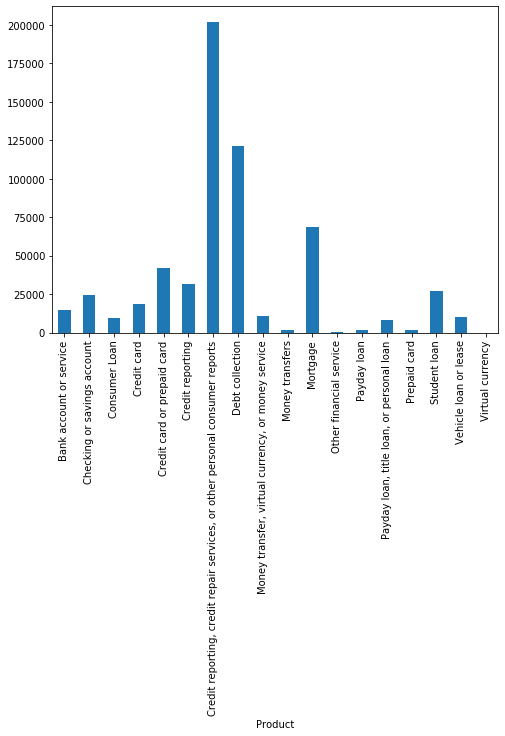

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [8]:
transformed_blaze_df = df[['category_id','Consumer_complaint_narrative']]
transformed_blaze_df.to_csv('transformed_for_blazingtext_complaints.csv')

In [9]:
transformed_blaze_df.head()
with open("transformed_for_blazingtext_complaints.csv") as myfile:
    head = [next(myfile) for x in range(5)]
print(head)

[',category_id,Consumer_complaint_narrative\n', '1,0,"Over the past 2 weeks, I have been receiving excessive amounts of telephone calls from the company listed in this complaint. The calls occur between XXXX XXXX and XXXX XXXX to my cell and at my job. The company does not have the right to harass me at work and I want this to stop. It is extremely distracting to be told 5 times a day that I have a call from this collection agency while at work."\n', '2,1,"Although I am checking for and addressing missing and or deficient aspects of REPORTING COMPLIANCES and not contesting any debt of compliant nature, I should make you aware that since unlawful reporting transitions collection into an equally not complaint circumstance. Being still yet not validated by document fact in compliance to requisite standards, it is to be announced yet again that legally I have no knowledge of the validity of the alleged claims of delinquency and or derogatory nature, nor of the certifiably compliant matter 

# Data Preprocessing
We need to preprocess the training data into space separated tokenized text format which can be consumed by BlazingText algorithm. Also, as mentioned previously, the class label(s) should be prefixed with __label__ and it should be present in the same line along with the original sentence. We'll use nltk library to tokenize the input sentences from DBPedia dataset.
Download the nltk tokenizer and other libraries

In [ ]:
from random import shuffle
import multiprocessing
from multiprocessing import Pool
import csv
import nltk
nltk.download('punkt')

In [ ]:
def transform_instance(row):
    cur_row = []
    label = "__label__" + row[1]  #Prefix the index-ed label with __label__
    cur_row.append(label)
    cur_row.extend(nltk.word_tokenize(row[2].lower()))
    return cur_row

In [ ]:
def preprocess(input_file, train_file, test_file, keep=1):
    all_rows = []
    remaining_rows = []
    with open(input_file, 'r') as csvinfile:
        csv_reader = csv.reader(csvinfile, delimiter=',')
        for row in csv_reader:
            all_rows.append(row)
    shuffle(all_rows)
    
    remaining_rows = all_rows[int(keep*len(all_rows)+1):int(len(all_rows)-1)]
    all_rows = all_rows[:int(keep*len(all_rows))]
    pool = Pool(processes=multiprocessing.cpu_count())
    train_rows = pool.map(transform_instance, all_rows)
    pool.close() 
    pool.join()
    
    pool2 = Pool(processes=multiprocessing.cpu_count())
    test_rows = pool2.map(transform_instance, remaining_rows)
    pool2.close() 
    pool2.join()
    
    
    with open(train_file, 'w') as csvoutfiletrain:
        csv_writer = csv.writer(csvoutfiletrain, delimiter=' ', lineterminator='\n')
        csv_writer.writerows(train_rows)
        
    with open(test_file, 'w') as csvoutfiletest:
        csv_writer = csv.writer(csvoutfiletest, delimiter=' ', lineterminator='\n')
        csv_writer.writerows(test_rows)
        

In [ ]:
%%time

# Preparing the training dataset

# Since preprocessing the whole dataset might take a couple of mintutes,
# we keep 70% of the training dataset for this demo.
# Set keep to 1 if you want to use the complete dataset
preprocess('transformed_for_blazingtext_complaints.csv', 'blazing_complaint_poc.train', 'blazing_complaint_poc.validation', keep=.7)

After the data preprocessing is complete, we need to upload it to S3 so that it can be consumed by SageMaker to execute training jobs. We'll use Python SDK to upload these two files to the bucket and prefix location that we have set above.

In [ ]:

%%time

train_channel = prefix + '/train'
validation_channel = prefix + '/validation'

sess.upload_data(path='blazing_complaint_poc.train', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='blazing_complaint_poc.validation', bucket=bucket, key_prefix=validation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)

Next we need to setup an output location at S3, where the model artifact will be dumped. These artifacts are also the output of the algorithm's traning job.

In [ ]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)


# Training
Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a sageMaker.estimator.Estimator object. This estimator will launch the training job.

In [ ]:
region_name = boto3.Session().region_name

In [ ]:
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))

In [ ]:
bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.c4.4xlarge',
                                         train_volume_size = 30,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

In [ ]:
bt_model.set_hyperparameters(mode="supervised",
                            epochs=10,
                            min_count=2,
                            learning_rate=0.05,
                            vector_dim=10,
                            early_stopping=True,
                            patience=4,
                            min_epochs=5,
                            word_ngrams=2)

In [20]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [21]:
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='text/plain', s3_data_type='S3Prefix')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [22]:
data_channels = {'train': train_data, 'validation': validation_data}

In [23]:
bt_model.fit(inputs=data_channels, logs=True)

2020-09-18 00:30:54 Starting - Starting the training job...
2020-09-18 00:30:58 Starting - Launching requested ML instances.........
2020-09-18 00:32:30 Starting - Preparing the instances for training...
2020-09-18 00:33:24 Downloading - Downloading input data...
2020-09-18 00:33:45 Training - Downloading the training image.Arguments: train
[09/18/2020 00:34:01 WARNING 140579398453056] Loggers have already been setup.
[09/18/2020 00:34:01 WARNING 140579398453056] Loggers have already been setup.
[09/18/2020 00:34:01 INFO 140579398453056] nvidia-smi took: 0.0502049922943 secs to identify 0 gpus
[09/18/2020 00:34:01 INFO 140579398453056] Running single machine CPU BlazingText training using supervised mode.
[09/18/2020 00:34:01 INFO 140579398453056] Processing /opt/ml/input/data/train/blazing_complaint_poc.train . File size: 436 MB
[09/18/2020 00:34:01 INFO 140579398453056] Processing /opt/ml/input/data/validation/blazing_complaint_poc.validation . File size: 187 MB
Read 10M words
Read 2

In [24]:
text_classifier = bt_model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!

In [25]:
category_id_df

,Product,category_id
1,Debt collection,0
2,"Credit reporting, credit repair services, or o...",1
18,"Money transfer, virtual currency, or money ser...",2
23,Mortgage,3
32,Student loan,4
45,Vehicle loan or lease,5
90,Credit card or prepaid card,6
157,Checking or savings account,7
255,Credit card,8
354,"Payday loan, title loan, or personal loan",9


In [51]:
sentences = ["In 1993apr21 045548 17418 news cs brandeis st922957 pip cc b."]

# using the same nltk tokenizer that we used during data preparation for training
tokenized_sentences = [' '.join(nltk.word_tokenize(sent)) for sent in sentences]

payload = {"instances" : tokenized_sentences}

response = text_classifier.predict(json.dumps(payload))

predictions = json.loads(response)
print(json.dumps(predictions, indent=2))

[
  {
    "prob": [
      0.08984027802944183
    ],
    "label": [
      "__label__6"
    ]
  },
  {
    "prob": [
      0.23318316042423248
    ],
    "label": [
      "__label__3"
    ]
  }
]


In [48]:
print(s3_validation_data)
!head s3://sagemaker-us-east-1-252379044400/blazing_text/validation/blazing_poc.validation

s3://sagemaker-us-east-1-252379044400/blazing_text/validation
head: cannot open ‘s3://sagemaker-us-east-1-252379044400/blazing_text/validation/blazing_poc.validation’ for reading: No such file or directory


In [28]:
sess.delete_endpoint(text_classifier.endpoint)